##라이브러리

In [ ]:
import tensorflow as tf
from tensorflow import keras

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")

print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

Go to Runtime > Change runtime and select a GPU hardware accelerator.


In [ ]:
import numpy as np
import os

랜덤 시드

In [ ]:
seed = 21
np.random.seed(seed)
tf.random.set_seed(seed)

## 코랩 세팅

In [ ]:
!apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
!pip install -q -U tf-agents pyvirtualdisplay gym[atari,box2d]

err: rom is missing에 대한 해결 방법

In [ ]:
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/

## matplot 세팅

In [ ]:
#figure을 예쁘게
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14) #그래프 포함 틀(cf.figure ) axes)
mpl.rc('xtick', labelsize=12) #틱은 눈금을 의미
mpl.rc('ytick', labelsize=12)

In [ ]:
#부드러운 애니메이션
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [ ]:
# save_fig
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

##matplot으로 애니메이션 만들기

한 episode를 실행하고 에니메이션을 위한 frames를 반환

In [ ]:
def render_policy_net(model, n_max_steps=200, random_seed=seed):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(random_seed)
    np.random.seed(random_seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

render_policy_net 함수에서 반환받은 frames를 인자로 받아 애니메이션 출력

In [ ]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

##시뮬레이션 환경: TF-Agents의 gym[atari] "Breakout-v4"

In [ ]:
from tf_agents.environments import suite_gym

env = suite_gym.load("Breakout-v4")
env

In [ ]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

# TF-Agents Environments

In [ ]:
env.gym

In [ ]:
env.seed(seed)
env.reset() #직접 관측을 반환하지는 않는다. 관측과 부가 정보를 감싼 TimeStep 객체 반환

In [ ]:
# step 매서도도 TimeStep 객체 반환
env.step(1) # Fire

In [ ]:
img = env.render(mode="rgb_array")

plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis("off")
save_fig("breakout_plot")
plt.show()

In [ ]:
env.current_time_step()

# 환경 스펙(Environment Specifications)

In [ ]:
env.observation_spec()
# shape=(210, 160, 3) : 단순 아타리 게임 화면의 스크린샷
# env.render(mode="human")을 호출하여 환경을 그릴 수 있다
# env.render(mode="rgb_array")를 호출하여 넘파이 배열 형태로 이미지를 받을 수 있다

BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)

In [ ]:
env.action_spec()

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)

In [ ]:
env.time_step_spec()

TimeStep(
{'discount': BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0),
 'observation': BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255),
 'reward': ArraySpec(shape=(), dtype=dtype('float32'), name='reward'),
 'step_type': ArraySpec(shape=(), dtype=dtype('int32'), name='step_type')})

In [ ]:
env.render(mode="human")

In [ ]:
env.render(mode="rgb_array")

In [ ]:
env.gym.get_action_meanings()

# Environment Wrappers

You can wrap a TF-Agents environments in a TF-Agents wrapper:

In [ ]:
from tf_agents.environments.wrappers import ActionRepeat

repeating_env = ActionRepeat(env, times=4) #행동을 time=n번 반복하면서 보상을 누적. 많은 환경에서 훈련 속도를 크게 높힐 수 있다.
repeating_env

In [ ]:
repeating_env.unwrapped

Here is the list of available wrappers:

In [ ]:
import tf_agents.environments.wrappers

#가능한 래퍼 종류
for name in dir(tf_agents.environments.wrappers):
    obj = getattr(tf_agents.environments.wrappers, name)
    if hasattr(obj, "__base__") and issubclass(obj, tf_agents.environments.wrappers.PyEnvironmentBaseWrapper):
        print("{:27s} {}".format(name, obj.__doc__.split("\n")[0]))

ActionClipWrapper           Wraps an environment and clips actions to spec before applying.
ActionDiscretizeWrapper     Wraps an environment with continuous actions and discretizes them.
ActionOffsetWrapper         Offsets actions to be zero-based.
ActionRepeat                Repeates actions over n-steps while acummulating the received reward.
ExtraDisabledActionsWrapper Adds extra unavailable actions.
FlattenObservationsWrapper  Wraps an environment and flattens nested multi-dimensional observations.
GoalReplayEnvWrapper        Adds a goal to the observation, used for HER (Hindsight Experience Replay).
HistoryWrapper              Adds observation and action history to the environment's observations.
ObservationFilterWrapper    Filters observations based on an array of indexes.
OneHotActionWrapper         Converts discrete action to one_hot format.
PerformanceProfiler         End episodes after specified number of steps.
PyEnvironmentBaseWrapper    PyEnvironment wrapper forwards calls

The `suite_gym.load()` function can create an env and wrap it for you, both with TF-Agents environment wrappers and Gym environment wrappers (the latter are applied first).

In [ ]:
from functools import partial
from gym.wrappers import TimeLimit

# 래핑하기
limited_repeating_env = suite_gym.load(
    "Breakout-v4",
    gym_env_wrappers=[partial(TimeLimit, max_episode_steps=10000)],
    env_wrappers=[partial(ActionRepeat, times=4)],
)

In [ ]:
limited_repeating_env

In [ ]:
limited_repeating_env.unwrapped

Create an Atari Breakout environment, and wrap it to apply the default Atari preprocessing steps:

**Warning**: Breakout requires the player to press the FIRE button at the start of the game and after each life lost. The agent may take a very long time learning this because at first it seems that pressing FIRE just means losing faster. To speed up training considerably, we create and use a subclass of the `AtariPreprocessing` wrapper class called `AtariPreprocessingWithAutoFire` which presses FIRE (i.e., plays action 1) automatically at the start of the game and after each life lost. This is different from the book which uses the regular `AtariPreprocessing` wrapper.

In [ ]:
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

max_episode_steps = 27000 # <=> 108k ALE frames since 1 step = 4 frames(1 스텝 = 4 프레임 이므로 108,000개 ALE 프레임)
environment_name = "BreakoutNoFrameskip-v4"

# AtariPreprocessing: 아타리 환경에서 표준적인 전처리
class AtariPreprocessingWithAutoFire(AtariPreprocessing):
    def reset(self, **kwargs):
        obs = super().reset(**kwargs)
        super().step(1) # FIRE to start
        return obs
    def step(self, action):
        lives_before_action = self.ale.lives()
        obs, rewards, done, info = super().step(action)
        if self.ale.lives() < lives_before_action and not done:
            super().step(1) # FIRE to start after life lost
        return obs, rewards, done, info

env = suite_atari.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessingWithAutoFire, FrameStack4])

In [ ]:
env

Play a few steps just to see what happens:

In [ ]:
env.seed(42)
env.reset()
for _ in range(4):
    time_step = env.step(3) # LEFT

In [ ]:
def plot_observation(obs):
    # Since there are only 3 color channels, you cannot display 4 frames
    # with one primary color per frame. So this code computes the delta between
    # the current frame and the mean of the other frames, and it adds this delta
    # to the red and blue channels to get a pink color for the current frame.
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")

Saving figure preprocessed_breakout_plot


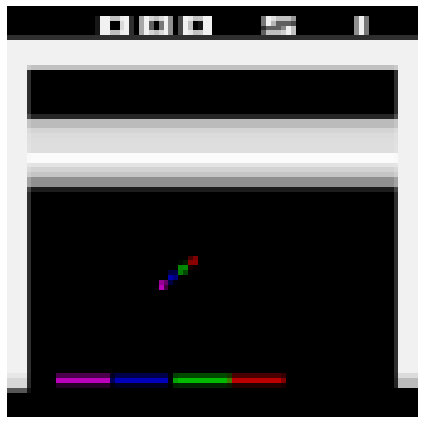

In [ ]:
plt.figure(figsize=(6, 6))
plot_observation(time_step.observation)
save_fig("preprocessed_breakout_plot")
plt.show()

Convert the Python environment to a TF environment:

In [ ]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment

# TFPyEnvironment 안에 이 환경 감싸기
tf_env = TFPyEnvironment(env)

# Creating the DQN

Create a small class to normalize the observations. Images are stored using bytes from 0 to 255 to use less RAM, but we want to pass floats from 0.0 to 1.0 to the neural network:

## Q-Network

QNetwork 클래스: 옵저버를 입력으로 받고 행동마다 하나의 Q-가치를 출력.<br>


In [ ]:
from tf_agents.networks.q_network import QNetwork

# 관측을 32비트 실수로 변환하고 정규화한다. 이 관측은 32비트 실수보다 4배나 작은 공간을 차지하는 부호 없는 바이트
preprocessing_layer = keras.layers.Lambda(
                          lambda obs: tf.cast(obs, np.float32) / 255.)
# 층이 3개인 CNN
# 1st: 8x8 필터 32개와 스트라이드 4
# 2nd: 4x4 필터 32개와 스트라이드 32
# 3rd: 8x8 필터 64개와 스트라이드 1
conv_layer_params=[(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]

# 뉴런 512개를 가진 fc layer
fc_layer_params=[512]

q_net = QNetwork(
    tf_env.observation_spec(), # 관측의 스펙
    tf_env.action_spec(), # 행동의 스펙

    preprocessing_layers=preprocessing_layer, #관측을 32비트 실수로 변환하고 정규화하는 층
    conv_layer_params=conv_layer_params, # 3개 층을 가진 CNN
    fc_layer_params=fc_layer_params) # fc layer

## DQN Agent

In [ ]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

train_step = tf.Variable(0) # 훈련 스텝 횟수
update_period = 4 # run a training step every 4 collect steps(4 스텝마다 모델을 훈련)
optimizer = keras.optimizers.RMSprop(lr=2.5e-4, rho=0.95, momentum=0.0, epsilon=0.00001, centered=True) # 옵티마이저(2015년 DQN 논문)

# ε-그리디 정책을 위한 ε값 계산을 위한 PolynomialDecay 객체
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, # initial ε(초기 ε)
    
    # 100만 ALE프레임 동안 1.0에서 0.01로 감소(2015년 DQN 논문)
    # 4 프레임마다 사용하므로 250,000 스텝에 해당
    # 에이전트가 4 스텝(16 ALE 프레임)마다 훈련되므로 ε은 62,500 훈련 스템에 걸쳐 감쇠
    decay_steps=250000 // update_period, # <=> 1,000,000 ALE frames(<=> 1,000,000 ALE 프레임)
    
    end_learning_rate=0.01) # final ε(마지막 ε)

# DQNAgent
agent = DqnAgent(
    tf_env.time_step_spec(), # 타임 스텝 스펙
    tf_env.action_spec(), # 행동 스펙
    q_network=q_net, # 훈련할 QNetwork
    optimizer=optimizer, # 옵티마이저
    target_update_period=2000, # 타깃 모델을 업데이트할 훈련 스텝 간격 <=> 32,000 ALE frames
    td_errors_loss_fn=keras.losses.Huber(reduction="none"), # 손실 함수
    gamma=0.99, # discount factor(할인 계수)
    train_step_counter=train_step, # train_step 변수
    epsilon_greedy=lambda: epsilon_fn(train_step)) # ε값을 반환하는 함수(이 함수는 매개변수가 없어야 하므로 train_step 변수를 전달하기 위해 lambda 사용)

# 에이전트 초기화
agent.initialize()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Replay Bufffer & Observer

this will use a lot of RAM, so please reduce the buffer size if you get an out-of-memory error

**Warning**: we use a replay buffer of size 100,000 instead of 1,000,000 (as used in the book) since many people were getting OOM (Out-Of-Memory) errors.

In [ ]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

# 균등 샘플링을 수행하는 고성능 재생 버퍼
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec, # 데이터 스펙: DQN 에이전트는 수집된 데이터의 구조를 알고 collect_data_spec속성을 참조할 수 있다)
    batch_size=tf_env.batch_size, # 각 스텝에서 추가될 경로의 개수(드라이버가 스텝마다 하나의 행동을 실행하고 하나의 경로를 수집하므로 이 값은 1)
    max_length=100000) # 재생 버터의 최대 크기(2015년 DQN 논문과 동일): 1백만개 경로를 저장할 수 있는 큰 재생 버퍼. 많은 RAM 필요

replay_buffer_observer = replay_buffer.add_batch # 재생 버퍼에 경로를 저장할 옵저버

Create a simple custom observer that counts and displays the number of times it is called (except when it is passed a trajectory that represents the boundary between two episodes, as this does not count as a step):

호출될 때마다 카운터를 증가시키는 간단한 옵저버(스텝으로 카운트하지 않는 두 에피소드 사이의 경계를 나타낼 때는 제외)

In [ ]:
# 100번 증가할 때마다 주어진 총게에 대한 진행 과정 표시
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

## Training Metrics

In [ ]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(), # 에피소드 횟수
    tf_metrics.EnvironmentSteps(), # 
    tf_metrics.AverageReturnMetric(), # 에피소드 당 평균 대가: 각 에피소드의 할인되지 않는 보상의 합을 구하고, 처리한 모든 에피소드에 대해 이 합의 스트리밍 평균을 관리
    tf_metrics.AverageEpisodeLengthMetric(), # 평균 에피소드 길이
]

In [ ]:
train_metrics[0].result() # 각 지표의 값 확인

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [ ]:
from tf_agents.eval.metric_utils import log_metrics
import logging
logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics) # 모든 지표를 로그에 기록

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


## Collect Driver

드라이버: 주어진 정책으로 환경을 탐색하고 경험을 수집하고 옵저버에 이를 전파하는 객체

각 스텝에서 드라이버가 수행하는 작업


*   드라이버는 현재 타임 스텝을 수집 정책에 전달. 수집 정책은 타임 스텝을 사용해 행동을 선택하고 행동을 포함한 행동 스텝을 반환
*   그다음 드라이버는 행동을 환경에 전달하고 다음 타임 스텝을 반환받는다
*   마지막으로 드라이버는 이 전이를 표현하는 경로 객체를 만들고 모든 옵저버에게 이를 전파







1.   드라이버가 **배치 타임 스텝**을 정책에 전달<br>
(관측의 배치, 스텝 타입의 배치, 보상의 배치, 할인의 배치를 포함한 타임 스텝 객체. 이 4개의 배치의 크기는 모두 같다)
2.   드라이버는 이전 정책 상태의 배치도 전달
3.   정책은 행동의 배치와 정책 상태의 배치를 담은 **배치 행동 스텝**을 반환
4.   드라이버는 **배치 경로**를 만든다<br>
(스텝 타입의 배치, 관측의 배치, 행돋의 배치, 보상의 배치와 각 경로의 속성에 대한 배치를 담은 경로. 모든 배치의 크기는 같다.)





In [ ]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

# (2015년 DQN 논문) 각 훈련 반복에서 스텝 4개에 대한 경험 수집
collect_driver = DynamicStepDriver(
    tf_env, # 환경
    agent.collect_policy, # 에이전트의 수집 정책
    observers=[replay_buffer_observer] + train_metrics, # 옵저버 리스트(재생 버퍼 옵저버와 훈련 지표)
    num_steps=update_period) # collect 4 steps for each training iteration(실행할 스텝 횟수. 여기서는 4)

# run() 메서드를 호출해서 실행할 수 있다
# BUT 랜덤 정책으로 수집된 경험을 미리 재생 버퍼에 채워 놓는 것이 좋다

Collect the initial experiences, before training:

In [ ]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

# (2015년 DQN 논문) 80,000개의 시뮬레이션 프레임으로
# RandomTFPolicy 클래스를 사용해 20,000 스텝 동안 이 정책을 실행하는 두번쨰 드라이버
# 재생 버퍼에 경험을 미리 채워 놓기 위해
initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),
                                        tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000) # <=> 80,000 ALE frames
final_time_step, final_policy_state = init_driver.run()

## Dataset

Let's sample 2 sub-episodes, with 3 time steps each and display them:

**Note**: `replay_buffer.get_next()` is deprecated. We must use `replay_buffer.as_dataset(..., single_deterministic_pass=False)` instead.

In [ ]:
tf.random.set_seed(9) # chosen to show an example of trajectory at the end of an episode

#trajectories, buffer_info = replay_buffer.get_next( # get_next() is deprecated
#    sample_batch_size=2, num_steps=3)

trajectories, buffer_info = next(iter(replay_buffer.as_dataset(
    sample_batch_size=2,
    num_steps=3,
    single_deterministic_pass=False)))

trajectories 객체는 7개 필드로 이뤄진 네임드 튜플<br>
경로가 2개 있고 각 스텝이 3개 있기 때문

In [ ]:
trajectories._fields 

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

observation필드 크기가 [2, 3, 84, 84, 4]<br>
: 첫 두 차원의 크기가 2와 3인 텐서.<br>
2개 경로에 대해 각 스텝이 3개 있고 각 스텝의 관측 크기는 84x84x4

In [ ]:
trajectories.observation.shape

TensorShape([2, 3, 84, 84, 4])

In [ ]:
from tf_agents.trajectories.trajectory import to_transition

# to_transition(): 경로(배치 time_step, 배치 action_step, 배치 next_time_step)를 담는 리스트로 변환
time_steps, action_steps, next_time_steps = to_transition(trajectories)
time_steps.observation.shape

TensorShape([2, 2, 84, 84, 4])

In [ ]:
trajectories.step_type.numpy()

array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)

In [ ]:
plt.figure(figsize=(10, 6.8))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row * 3 + col + 1)
        plot_observation(trajectories.observation[row, col].numpy())
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0.02)
save_fig("sub_episodes_plot")
plt.show()

Now let's create the dataset:

In [ ]:
#tf.data.Dataset: Data API의 장점(병렬화와 프리페칭)을 사용할 수 있다
dataset = replay_buffer.as_dataset( # (2015년 DQN 논문)
    sample_batch_size=64, # 훈련 스텝마다 64개 경로의 배치를 샘플링
    num_steps=2, # 각 경로는 2개의 스텝을 포함(2개의 스텝 = 다음 스텝의 관측을 가진 1개의 완전한 전이)
    num_parallel_calls=3).prefetch(3) # 이 데이터셋은 3개를 병렬로 처리하고 3개의 배치를 프리페치

## Main Training Loop

Convert the main functions to TF Functions for better performance:

In [ ]:
from tf_agents.utils.common import function

# 훈련 속도를 높이기 위해 주 함수를 텐서플로 함수로 변경
# : tf.function()를 감싸고 실험적인 옵션을 추가한 tf_agents.utils.common.function() 함수를 사용
collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

In [ ]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size) # 초기 상태(환경의 배치 크기 전달. 이 경우는 1): 이 정책은 상태가 없기 때문에 빈 튜플 반환(policy_state = () )

    iterator = iter(dataset)
    for iteration in range(n_iterations):
        
        # 수집 정책 실행, 4 스텝 동안 경험을 수집
        time_step, policy_state = collect_driver.run(time_step, policy_state) 

        # 수집된 경로를 재생 버퍼와 지표에 전달
        trajectories, buffer_info = next(iterator)

        # 데이터셋에서 경로의 배치 하나를 샘플링하여 에이전트의 train() 메서드에 전달
        train_loss = agent.train(trajectories) #train_loss 객체를 반환

        # 반복 횟수와 훈련 손실을 출력
        print("\r{} loss:{:.5f}".format(
            iteration, train_loss.loss.numpy()), end="")
        # 1,000번 반복 마다 모든 지표를 로그에 기록
        if iteration % 1000 == 0:
            log_metrics(train_metrics)

Run the next cell to train the agent for 50,000 steps. Then look at its behavior by running the following cell. You can run these two cells as many times as you wish. The agent will keep improving! It will likely take over 200,000 iterations for the agent to become reasonably good.

In [ ]:
train_agent(n_iterations=50000)

In [ ]:
frames = []
def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, ShowProgress(1000)],
    num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()

plot_animation(frames)

If you want to save an animated GIF to show off your agent to your friends, here's one way to do it:

In [ ]:
import PIL

image_path = os.path.join("images", "rl", "breakout.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:150]]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)

In [ ]:
%%html
<img src="images/rl/breakout.gif" />